## Load image

Next, let's load an image.

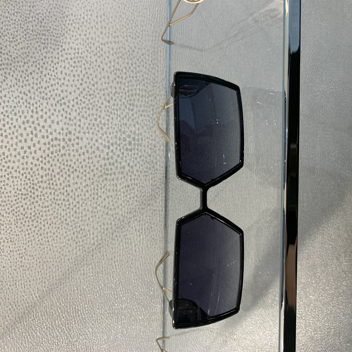

In [189]:
from PIL import Image

path = "data/test_image_headmind/image-20210928-103157-a46cc321.jpg"
image = Image.open(path)
image = image.resize((352, 352))
image

## Load model

Next, let's load the model and its processor from the [hub](https://huggingface.co/CIDAS/clipseg-rd64-refined).

In [3]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

model.safetensors:  80%|#######9  | 482M/603M [00:00<?, ?B/s]

## Prepare image and texts for model

The image and a few prompts can be prepared for the model using the processor.

In [190]:
prompts = ["glasses"]

inputs = processor(
    text=prompts,
    images=[image] * len(prompts),
    padding="max_length",
    return_tensors="pt",
    
)

/home/idriss/.local/share/mamba/envs/challenge_mention/lib/python3.12/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)


## Forward pass

Next, let's run a forward pass and visualize the predictions the model made.

[Text(0, -15, 'glasses')]

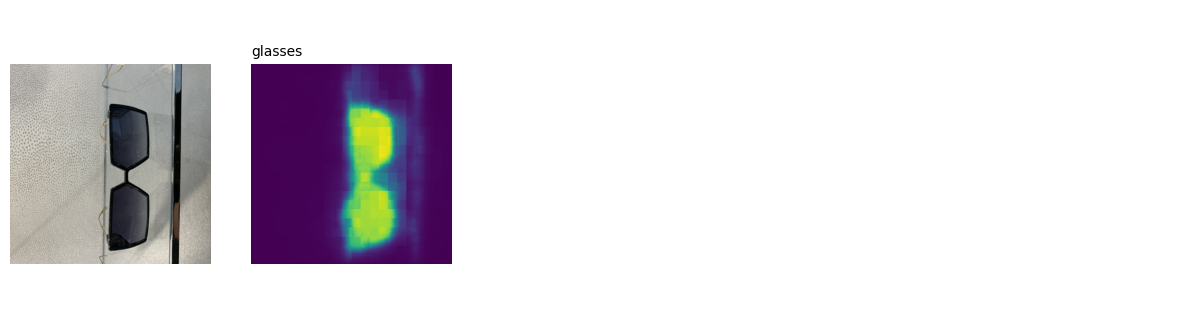

In [191]:
import torch
import matplotlib.pyplot as plt

# predict
with torch.no_grad():
    outputs = model(**inputs)

preds = outputs.logits.unsqueeze(1)

# visualize prediction
_, ax = plt.subplots(1, 5, figsize=(15, 4))
[a.axis("off") for a in ax.flatten()]
ax[0].imshow(image)
[ax[i + 1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))]
[ax[i + 1].text(0, -15, prompts[i]) for i in range(len(prompts))]

As can be seen, the model is capable of segmenting images based on text prompts in a zero-shot manner. Pretty cool, huh?

## Convert to binary mask

To convert to a binary mask, I borrow some logic from [here](https://github.com/amrrs/stable-diffusion-prompt-inpainting). One can apply a sigmoid activation function on the predicted mask and use some OpenCV (cv2) to turn it into a binary mask. 

In [192]:
filename = "mask.png"
# here we save the second mask
plt.imsave(filename, torch.sigmoid(preds[0][0]))

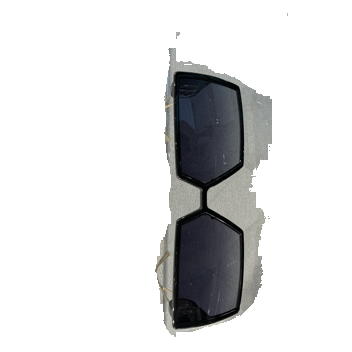

In [193]:
import numpy as np
from PIL import Image

mask = Image.open(filename)
mask = mask.resize(image.size)  # resize mask to image size
mask = np.array(mask)[:, :, :3]  # convert mask to numpy array

mask = np.mean(mask, axis=2)
mask = np.where(mask > np.quantile(mask, q=0.8), 1, 0)

# apply mask to image
output_image = np.array(image)
output_image[mask == 0] = 255

# mask = np.mean(mask, axis=2, keepdims=True)  # take the max value along the last axis (3 channels)
# mask = np.where(mask > 80, 255, mask)

# mask = mask - mask.min()

# # white image
# white_image = np.ones_like(image) * 255

# output_image = white_image*(1-mask/255) + np.array(image) * (mask/255)

Image.fromarray(output_image.astype(np.uint8))




# # convert image to PIL image
# image = Image.fromarray(image)
# image